## 1. Use adapted variant of the categorise function

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import unidecode
sns.set_context("talk")


def categorise(source, target):
    """
    Return a numerical label indicating inflection class.

    Args:
        source (str): source with gender as first character ("<f> k a t z e ")
        target (str): (predicted) target

    Returns:
        int indicating class, ranges from 0 - 6
    """
    assert "<" in source.split()[0], "Your source sequence has no gender tag!"

    source = source.replace(" </s>", "")
    target = target.replace(" </s>", "")
    source = unidecode.unidecode(source).split()[1:]
    target = unidecode.unidecode(target).split()

    # zero or epsilon
    if target == source:
        category = 2
    else:
        # (e)n
        if source[-1] != "n" and target[-1:] == ["n"]:
            category = 0
        # e
        elif source[-1] != "e" and target[-1:] == ["e"]:
            category = 1
        # e r
        elif source[-2:] != ["e", "r"] and target[-2:] == ["e", "r"]:
            category = 3
        # s
        elif source[-1] != "s" and target[-1:] == ["s"]:
            category = 4
        # repeated input but odd suffix
        else:
            category = 5
    return category


## 2. Visualise!

<Figure size 432x288 with 0 Axes>

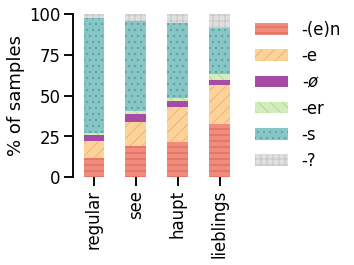

In [4]:
import pandas as pd
import unidecode
import numpy as np
from matplotlib.colors import ListedColormap
from colormap import rgb2hex


def combine_hex_values(d):
    d_items = sorted(d.items())
    tot_weight = sum(d.values())
    red = int(sum([int(k[:2], 16)*v for k, v in d_items])/tot_weight)
    green = int(sum([int(k[2:4], 16)*v for k, v in d_items])/tot_weight)
    blue = int(sum([int(k[4:6], 16)*v for k, v in d_items])/tot_weight)
    zpad = lambda x: x if len(x)==2 else '0' + x
    return zpad(hex(red)[2:]) + zpad(hex(green)[2:]) + zpad(hex(blue)[2:])


data = dict()
for setup, name in [("", "regular"), ("_see", "see"),
                    ("_haupt", "haupt"),
                    ("_lieblings", "lieblings")]:
    lengths = []
    counts = Counter()
    for seed in range(1, 6):
        filename = f"../opennmt/models/seed={seed}_wiktionary/length/lstms2s_length{setup}_25.prd"
        with open(f"../wiktionary/s_length{setup}.src", encoding="utf-8") as f_src, \
             open(filename, encoding="utf-8") as f_prd:
            for src, tgt in zip(f_src, f_prd):
                lengths.append(len(src.split()))
                cat = categorise(src, tgt)
                if cat == 6:
                    cat = 5
                counts[cat] += 1
    data[name] = {x: counts[x] / (17 * 6 * 5) * 100 for x in range(6)}

fig = plt.figure()
a = pd.DataFrame(data)
colours = sns.color_palette("Spectral", 5) + [(211/255, 211/255, 211/255)]
colours2 = sns.color_palette("Spectral", 5) + [(211/255, 211/255, 211/255)]
colours[2] = "purple"

ax = a.T.plot(kind="bar", stacked=True, colormap=ListedColormap(colours), alpha=0.7,
              figsize=(3, 3))
ax.set_xticklabels(a.keys())
plt.ylabel("")
ax.set_yticks([0, 25, 50, 75, 100])
ax.set_yticklabels([0, 25, 50, 75, 100])

# Define some hatches
hatches = ['--'] * 4 + ['//'] * 4 + [''] * 4 + \
          ['\\\\'] * 4 + ['..'] * 4 + ['++'] * 4

# Add the hatches
for i, thisbar in enumerate(ax.patches):
    a, b, c = colours2[int(i/4)]
    c = rgb2hex(int(a*255), int(b*255), int(255*c)).replace('#', '')
    thisbar.set_hatch(hatches[i])
    thisbar.set_edgecolor("#" + combine_hex_values({"000000": 0.1, c: 0.9}))
    thisbar.set_linewidth(0)

plt.ylabel("% of samples")
plt.ylim(0, 100)
sns.despine(bottom=True, right=True, top=True)
plt.legend(frameon=False, bbox_to_anchor=(1, 1.05), labels=["-(e)n", "-e", r"-$\o$", "-er", "-s", "-?"])
plt.savefig(f"figures/s_length.pdf", bbox_inches="tight",
            facecolor=fig.get_facecolor(), edgecolor="black")
plt.show()